In [1]:
import pickle
import numpy as np
from scipy.stats import entropy
from tqdm import tqdm
from datasets import load_dataset

## Reading Cached GPT-3 Outputs

In [2]:
# indices in WikiBio of the evaluated examples
ids = load_dataset("potsawee/wiki_bio_gpt3_hallucination")['evaluation']['wiki_bio_test_idx']

Using custom data configuration potsawee--wiki_bio_gpt3_hallucination-9bba6a0f21f1b815
Found cached dataset parquet (/home/pm574/rds/hpc-work/downloads/hf_datasets/potsawee___parquet/potsawee--wiki_bio_gpt3_hallucination-9bba6a0f21f1b815/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

For the files below, you could download them at https://drive.google.com/file/d/1t3pJt0o395rdPHK6h6S3s0bxnscQGzK0/view?usp=drive_link 

In [3]:
# GPT-3's reponse
# response = openai.Completion.create(
#     model="text-davinci-003",
#     prompt=f"This is a passage from Wikipedia about {context}:\n\n",
#     temperature=temperature, # 0.0 = deterministic
#     max_tokens=max_length,
#     logprobs=logprobs,
# )
# type(response.choices[0].text)     => str
# type(response.choices[0].logprobs) => openai.openai_object.OpenAIObject

responses = {}
for idx in ids:
    path = f"/home/pm574/rds/hpc-work/self-consistency/llm_outputs/passage_top_length/gpt3_davinci_003_FEB15_v1_logprob/{idx}.bin"
    with open(path, "rb") as f:
        response = pickle.load(f)
    responses[idx] = response

## load `wiki_bio_gpt3_hallucination` data

In [4]:
dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")
dataset = dataset['evaluation']

Using custom data configuration potsawee--wiki_bio_gpt3_hallucination-9bba6a0f21f1b815
Found cached dataset parquet (/home/pm574/rds/hpc-work/downloads/hf_datasets/potsawee___parquet/potsawee--wiki_bio_gpt3_hallucination-9bba6a0f21f1b815/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
label_mapping = {
    'accurate': 0.0,
    'minor_inaccurate': 0.5,
    'major_inaccurate': 1.0,
}

In [6]:
human_label_detect_False   = {}
human_label_detect_False_h = {}
human_label_detect_True    = {}
for i_ in range(len(dataset)):
    dataset_i = dataset[i_]
    idx = dataset_i['wiki_bio_test_idx']
    raw_label = np.array([label_mapping[x] for x in dataset_i['annotation']])
    human_label_detect_False[idx] = (raw_label > 0.499).astype(np.int32).tolist()
    human_label_detect_True[idx]  = (raw_label < 0.499).astype(np.int32).tolist()
    average_score = np.mean(raw_label)
    if average_score < 0.99:
        human_label_detect_False_h[idx] = (raw_label > 0.99).astype(np.int32).tolist()

In [7]:
len(human_label_detect_False), len(human_label_detect_True), len(human_label_detect_False_h)

(238, 238, 206)

# Experimental Setup

In [8]:
def unroll_pred(scores, indices):
    unrolled = []
    for idx in indices:
        unrolled.extend(scores[idx])
    return unrolled

In [9]:
def get_PR_with_human_labels(preds, human_labels, pos_label=1, oneminus_pred=False):
    indices = [k for k in human_labels.keys()]
    unroll_preds = unroll_pred(preds, indices)
    if oneminus_pred:
        unroll_preds = [1.0-x for x in unroll_preds]
    unroll_labels = unroll_pred(human_labels, indices)
    assert len(unroll_preds) == len(unroll_labels)
    print("len:", len(unroll_preds))
    P, R, thre = precision_recall_curve(unroll_labels, unroll_preds, pos_label=pos_label)
    return P, R

In [10]:
def print_AUC(P, R):
    print("AUC: {:.2f}".format(auc(R, P)*100))

In [11]:
baseline1_scores = {} # average_logprob
baseline2_scores = {} # lowest_logprob
baseline3_scores = {} # average_entropy5
baseline4_scores = {} # highest_entropy5

In [12]:
for i_ in tqdm(range(len(dataset))):
    dataset_i = dataset[i_]
    idx = dataset_i['wiki_bio_test_idx']
    sentences = dataset_i['gpt3_sentences']
    num_sentences = len(sentences)
    
    # from the cache
    passage = responses[idx].choices[0].text
    tokens = responses[idx].choices[0].logprobs.tokens
    token_logprobs = responses[idx].choices[0].logprobs.token_logprobs
    top_logprobs = responses[idx].choices[0].logprobs.top_logprobs
    
    average_logprob_sent_level = [None for _ in range(num_sentences)]
    lowest_logprob_sent_level = [None for _ in range(num_sentences)]
    average_entropy5_sent_level = [None for _ in range(num_sentences)]
    highest_entropy5_sent_level = [None for _ in range(num_sentences)]
        
    for sent_i, sentence in enumerate(sentences):
        # sentence exist in the passage, so we need to find where it is [i1, i2]
        xarr = [i for i in range(len(tokens))]
        for i1 in xarr:
            mystring = "".join(tokens[i1:])
            if sentence not in mystring:
                break
        i1 = i1 - 1
        for i2 in xarr[::-1]:
            mystring = "".join(tokens[i1:i2+1])
            if sentence not in mystring:
                break
        i2 = i2 + 1
        mystring = "".join(tokens[i1:i2+1])
        average_logprob = np.mean(token_logprobs[i1:i2+1])
        lowest_logprob  = np.min(token_logprobs[i1:i2+1])
        entropy5s = []
        for top5_tokens in top_logprobs[i1:i2+1]:
            logprob_of_top5_tokens = [x[1] for x in list(top5_tokens.items())]
            logprob_of_top5_tokens = np.array(logprob_of_top5_tokens)
            prob_of_top5_tokens = np.exp(logprob_of_top5_tokens)
            total_prob_of_top5 = prob_of_top5_tokens.sum()
            normalized_prob = prob_of_top5_tokens / total_prob_of_top5
            # this was designed to be PPL, and intial results showed a better performance level than just entropy
            entropy5 = 2**(entropy(normalized_prob, base=2)) 
            entropy5s.append(entropy5)
        average_entropy5 = np.mean(entropy5s)
        highest_entropy5 = np.max(entropy5s)

        average_logprob_sent_level[sent_i] = average_logprob
        lowest_logprob_sent_level[sent_i] = lowest_logprob
        average_entropy5_sent_level[sent_i] = average_entropy5
        highest_entropy5_sent_level[sent_i] = highest_entropy5

    baseline1_scores[idx] = average_logprob_sent_level
    baseline2_scores[idx] = average_entropy5_sent_level
    baseline3_scores[idx] = lowest_logprob_sent_level
    baseline4_scores[idx] = highest_entropy5_sent_level

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:01<00:00, 206.39it/s]


## Experiment1: Detecting False

In [13]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

In [14]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(baseline1_scores, human_label_detect_False, pos_label=1, oneminus_pred=True)
Pb2, Rb2 = get_PR_with_human_labels(baseline2_scores, human_label_detect_False, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(baseline3_scores, human_label_detect_False, pos_label=1, oneminus_pred=True)
Pb4, Rb4 = get_PR_with_human_labels(baseline4_scores, human_label_detect_False, pos_label=1)
print("-----------------------")
print("Baseline1: Avg(logP)")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("Baseline2: Avg(H)")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("Baseline3: Max(-logP)")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("Baseline4: Max(H)")
print_AUC(Pb4, Rb4)

len: 1908
len: 1908
len: 1908
len: 1908
-----------------------
Baseline1: Avg(logP)
AUC: 83.21
-----------------------
Baseline2: Avg(H)
AUC: 80.73
-----------------------
Baseline3: Max(-logP)
AUC: 87.51
-----------------------
Baseline4: Max(H)
AUC: 85.75


In [15]:
arr = []
for v in human_label_detect_False.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.7295597484276729

Text(0.5, 0, 'Recall')

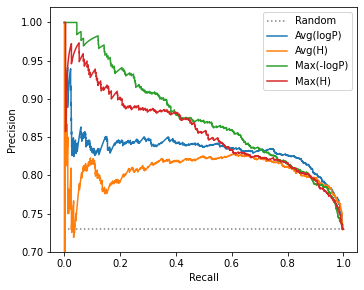

In [16]:
# with human label, Detecting Non-factual
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='Avg(logP)')
plt.plot(Rb2, Pb2, '-', label='Avg(H)')
plt.plot(Rb3, Pb3, '-', label='Max(-logP)')
plt.plot(Rb4, Pb4, '-', label='Max(H)')
plt.legend()
plt.ylim(0.7,1.02)
plt.ylabel("Precision")
plt.xlabel("Recall")

## Experiment2: Detect False* (harder/less-trivial)

In [17]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(baseline1_scores, human_label_detect_False_h, pos_label=1, oneminus_pred=True)
Pb2, Rb2 = get_PR_with_human_labels(baseline2_scores, human_label_detect_False_h, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(baseline3_scores, human_label_detect_False_h, pos_label=1, oneminus_pred=True)
Pb4, Rb4 = get_PR_with_human_labels(baseline4_scores, human_label_detect_False_h, pos_label=1)
print("-----------------------")
print("Baseline1: Avg(logP)")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("Baseline2: Avg(H)")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("Baseline3: Max(-logP)")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("Baseline4: Max(H)")
print_AUC(Pb4, Rb4)

len: 1632
len: 1632
len: 1632
len: 1632
-----------------------
Baseline1: Avg(logP)
AUC: 38.89
-----------------------
Baseline2: Avg(H)
AUC: 37.09
-----------------------
Baseline3: Max(-logP)
AUC: 35.88
-----------------------
Baseline4: Max(H)
AUC: 32.43


In [18]:
arr = []
for v in human_label_detect_False_h.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.2971813725490196

Text(0.5, 0, 'Recall')

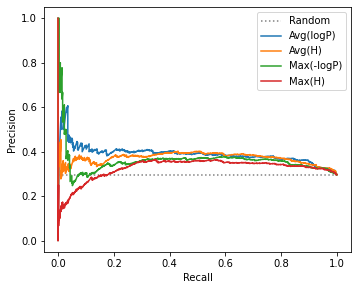

In [19]:
# with human label, Detecting Non-factual*
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='Avg(logP)')
plt.plot(Rb2, Pb2, '-', label='Avg(H)')
plt.plot(Rb3, Pb3, '-', label='Max(-logP)')
plt.plot(Rb4, Pb4, '-', label='Max(H)')
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")

## Experiment3: Detecting True

In [20]:
# with human label, Detecting True
Pb1, Rb1 = get_PR_with_human_labels(baseline1_scores, human_label_detect_True, pos_label=1, oneminus_pred=False)
Pb2, Rb2 = get_PR_with_human_labels(baseline2_scores, human_label_detect_True, pos_label=1, oneminus_pred=True)
Pb3, Rb3 = get_PR_with_human_labels(baseline3_scores, human_label_detect_True, pos_label=1, oneminus_pred=False)
Pb4, Rb4 = get_PR_with_human_labels(baseline4_scores, human_label_detect_True, pos_label=1, oneminus_pred=True)
print("-----------------------")
print("Baseline1: Avg(logP)")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("Baseline2: Avg(H)")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("Baseline3: Max(-logP)")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("Baseline4: Max(H)")
print_AUC(Pb4, Rb4)

len: 1908
len: 1908
len: 1908
len: 1908
-----------------------
Baseline1: Avg(logP)
AUC: 53.97
-----------------------
Baseline2: Avg(H)
AUC: 52.07
-----------------------
Baseline3: Max(-logP)
AUC: 50.46
-----------------------
Baseline4: Max(H)
AUC: 50.27


In [21]:
arr = []
for v in human_label_detect_True.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.27044025157232704

Text(0.5, 0, 'Recall')

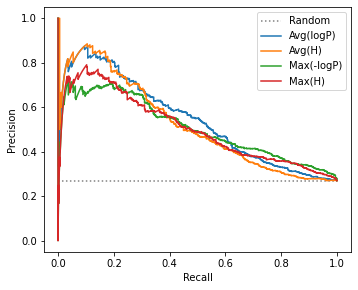

In [22]:
# with human label, Detecting Non-factual*
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='Avg(logP)')
plt.plot(Rb2, Pb2, '-', label='Avg(H)')
plt.plot(Rb3, Pb3, '-', label='Max(-logP)')
plt.plot(Rb4, Pb4, '-', label='Max(H)')
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")